## Knowledge Graph

### Rutvik Patel (17BCE0729)

**Importing modules**

In [1]:
#@Author: Rutvik Patel (17BCE0729)
#@Description: NER, extract keywords, rank, plot, community detection.

import nltk
from string import punctuation
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
import sys
from collections import defaultdict
import spacy
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
from matplotlib import cm

**Ranking and keyword extraction utility**

In [2]:
class TextRankGraph:
    def __init__(self):
        self.graph = defaultdict(list)
        self.d = 0.9 # damping coefficient, usually is .85 (in paper)
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 1000 # iteration steps

    def addEdge(self, start, end, weight):
        """Add edge between node"""
        self.graph[start].append((start, end, weight))
        self.graph[end].append((end, start, weight))

    def rank(self):
        """Rank all nodes"""
        weight_deafault = 1.0 / (len(self.graph) or 1.0) # initialize weight
        nodeweight_dict = defaultdict(float) # store weight of node
        outsum_node_dict = defaultdict(float) # store wegiht of out nodes
        for node, out_edge in self.graph.items(): # initilize nodes weight by edges
            # node: was
            # out_edge: [('was', 'prison', 1), ('was', 'wrong', 1), ('was', 'bad', 1)]
            nodeweight_dict[node] = weight_deafault
            outsum_node_dict[node] = sum((edge[2] for edge in out_edge), 0.0) # if no out edge, set weight 0
        
        sorted_keys = sorted(self.graph.keys()) # save node name as a list for iteration
        step_dict = [0]
        for step in range(1, self.steps):
            for node in sorted_keys:
                s = 0
                # Node's weight calculation: 
                # (edge_weight/ node's number of out link)*node_weight[edge_node]
                for e in self.graph[node]:
                    s += e[2] / outsum_node_dict[e[1]] * nodeweight_dict[e[1]]
                # Update calculation: (1-d) + d*s
                nodeweight_dict[node] = (1 - self.d) + self.d * s
            step_dict.append(sum(nodeweight_dict.values()))

            if abs(step_dict[step] - step_dict[step - 1]) <= self.min_diff:
                break

        # min-max scale to make result in range to [0 - 1]
        min_rank, max_rank = 0, 0 # initilize max and min wegiht value
        for w in nodeweight_dict.values():
            if w < min_rank:
                min_rank = w
            if w > max_rank:
                max_rank = w

        for n, w in nodeweight_dict.items():
            nodeweight_dict[n] = (w - min_rank/10.0) / (max_rank - min_rank/10.0)

        return nodeweight_dict


class TextRank:
    """Extract keywords based on textrank graph algorithm"""
    def __init__(self):
        self.candi_pos = ['NOUN', 'PROPN', 'VERB'] 
        self.stop_pos = ['NUM', 'ADV']
        self.span = 5

    def extract_keywords(self, word_list, num_keywords):
        g = TextRankGraph()
        cm = defaultdict(int)
        for i, word in enumerate(word_list): # word_list = [['previous', 'ADJ'], ['rumor', 'NOUN']]
            if word[1] in self.candi_pos and len(word[0]) > 1: # word = ['previous', 'ADJ']
                for j in range(i + 1, i + self.span):
                    if j >= len(word_list):
                        break
                    if word_list[j][1] not in self.candi_pos or word_list[j][1] in self.stop_pos or len(word_list[j][0]) < 2:
                        continue
                    pair = tuple((word[0], word_list[j][0]))
                    cm[(pair)] +=  1

        # cm = {('was', 'prison'): 1, ('become', 'prison'): 1}
        for terms, w in cm.items():
            g.addEdge(terms[0], terms[1], w)
        nodes_rank = g.rank()
        nodes_rank = sorted(nodes_rank.items(), key=lambda asd:asd[1], reverse=True)

        return nodes_rank[:num_keywords]

In [3]:
#     def generate_communities(self):
#         communities = list(nx.algorithms.community.centrality.girvan_newman(self.KG, most_valuable_edge = None))
#         return(communities)
    
#     def show_communities(self):
#         communities = self.generate_communities()
#         partition = nx.algorithms.community.label_propagation.asyn_lpa_communities(self.KG, weight = None, seed = None)
#         pos = community_layout(self.KG, partition)
#         nx.draw(self.KG, pos, node_color=list(partition.values()))
#         plt.show()
#         return

**Graph generation and plotting utility**

In [4]:
class Grapher():
    def __init__(self):
        self.KG = nx.DiGraph()
        self.comm_lvl_thresh = 4
    
    def create_graph(self, events):
        nodes = []
#         print(len(events))
        for event in events:
            nodes.append(event[0])
            nodes.append(event[1])
        node_dict = {node: index for index, node in enumerate(nodes)}
        
        data_nodes = []
        data_edges = []
        for node, id in node_dict.items():
            data = {}
            data["group"] = 'Event'
            data["id"] = id
            data["label"] = node
            data_nodes.append(data)
            self.KG.add_node(node, event = 'Event', ID = id, label = node)

        for edge in events:
            data = {}
            data['from'] = node_dict.get(edge[0])
            data['label'] = ''
            data['to'] = node_dict.get(edge[1])
            data_edges.append(data)
            self.KG.add_edge(edge[0], edge[1], label = '')
        
#         print(data_nodes, data_edges)
#         print(len([data['label'] for data in data_nodes]), KG.order())
        return(self.KG)
    
    def show_graph(self, colour_map = []):
        df = pd.DataFrame(index = self.KG.nodes(), columns = self.KG.nodes())
        for row, data in nx.shortest_path_length(self.KG):
            for col, dist in data.items():
                df.loc[row, col] = dist
        df = df.fillna(df.max().max())
        
        if colour_map == []:
            colour_map = ['darkorange' for _ in range(len(self.KG.nodes))]
        
        min_in_degree = min([self.KG.in_degree(node) for node in self.KG])
        plt.figure(figsize =(20, 20))
        nx.draw_networkx(self.KG, pos =  nx.kamada_kawai_layout(self.KG, dist = df.to_dict()), arrows = True,
                         with_labels = True, node_shape = 'o', font_color = 'black', node_color = colour_map,
                         node_size = [300 * ((self.KG.in_degree(node) + 1) / (min_in_degree + 1)) for node in self.KG])
        return
    
    def show_nodes(self):
        for node in self.KG.nodes:
            print(node)
        print()
        return
    
    def get_graph(self):
        return(self.KG)
    
    def show_communities(self):
        comp = list(nx.algorithms.community.centrality.girvan_newman(self.KG))
        levels, colour_map, labels = len(comp), [], []
        commLabels = [(comp[levels // self.comm_lvl_thresh][i], i) for i in range(len(comp[levels // self.comm_lvl_thresh]))]
        nodes = {node : -1 for node in self.KG.nodes}
        colours = cm.get_cmap('rainbow', len(commLabels))
        
        for node in nodes:
            for commLabel in commLabels:
                if node in commLabel[0]:
                    labels.append(commLabel[1])
                    colour_map.append(colours(commLabel[1]))
        print(labels)
        self.show_graph(colour_map)
        return

**NER**

In [5]:
class KnowledgeMining():
    def __init__(self, nlp):
        self.textranker = TextRank()
        self.ners = ['PERSON', 'ORG', 'GPE']
        self.ner_dict = {
            'PERSON': 'Person',  # People, includes fictional
            'ORG': 'Organization',  # Companies, agencies, institutions, etc.
            'GPE': 'Location',  # Countries, cities, states.
        }
        # dependency markers for subjects
        self.SUBJECTS = {"nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"}
        # dependency markers for objects
        self.OBJECTS = {"dobj", "dative", "attr", "oprd"}
        self.grapher = Grapher()
        self.nlp = nlp

    def clean_spaces(self, s): 
        s = s.replace('\r', '')
        s = s.replace('\t', ' ')
        s = s.replace('\n', ' ')
        return s

    def remove_noisy(self, content):
        """Remove brackets"""
        p1 = re.compile(r'（[^）]*）')
        p2 = re.compile(r'\([^\)]*\)')
        return(p2.sub('', p1.sub('', content)))

    def collect_ners(self, ents):
        """Collect token only with PERSON, ORG, GPE"""
        collected_ners = []
        for token in ents:
            if token.label_ in self.ners:
                collected_ners.append(token.text + '/' + token.label_)
        return collected_ners

    def conll_syntax(self, sent):
        """Convert one sentence to conll format."""
        tuples = list()
        for word in sent:
            if word.head is word:
                head_idx = 0
            else:
                head_idx = word.head.i + 1
            tuples.append([word.i + 1,  # Current word index, begin with 1
                           word.text,  # Word
                           word.lemma_,  # Lemma
                           word.pos_,  # Coarse-grained tag
                           word.tag_,  # Fine-grained tag
                           '_',
                           head_idx,  # Head of current  Index
                           word.dep_,  # Relation
                           '_', '_'])
        return tuples

    def syntax_parse(self, sent):
        """Convert one sentence to conll format."""
        tuples = list()
        for word in sent:
            if word.head is word:
                head_idx = 0
            else:
                head_idx = word.head.i + 1
            tuples.append([word.i + 1,  # Current word index, begin with 1
                           word.text,  # Word
                           word.pos_,  # Coarse-grained tag - basic
                           word.head,
                           head_idx,  # Head of current  Index
                           word.dep_,  # Relation
                           ])
        return tuples

    def build_parse_child_dict(self, sent, tuples):
        child_dict_list = list()
        for word in sent:
            child_dict = dict()
            for arc in tuples:
                if arc[3] == word:
                    if arc[-1] in child_dict:
                        child_dict[arc[-1]].append(arc)
                    else:
                        child_dict[arc[-1]] = []
                        child_dict[arc[-1]].append(arc)
            child_dict_list.append([word, word.pos_, word.i, child_dict])
        return child_dict_list

    def complete_VOB(self, verb, child_dict_list):
        for child in child_dict_list:
            word = child[0]
            # child_dict: {'dobj': [[7, 'startup', 'NOUN', buying, 5, 'dobj']], 'prep': [[8, 'for', 'ADP', buying, 5, 'prep']]}
            child_dict = child[3]
            if word == verb:
                for object_type in self.OBJECTS:  # object_type: 'dobj'
                    if object_type not in child_dict:
                        continue
                    # [7, 'startup', 'NOUN', buying, 5, 'dobj']
                    vob = child_dict[object_type][0]
                    obj = vob[1]  # 'startup'
                    return obj
        return ''

    def extract_triples(self, sent):
        svo = []
        tuples = self.syntax_parse(sent)
        child_dict_list = self.build_parse_child_dict(sent, tuples)
        for tuple in tuples:
            rel = tuple[-1]
            if rel in self.SUBJECTS:
                sub_wd = tuple[1]
                verb_wd = tuple[3]
                obj = self.complete_VOB(verb_wd, child_dict_list)
                subj = sub_wd
                verb = verb_wd.text
                if not obj:
                    svo.append([subj, verb])
                else:
                    svo.append([subj, verb + ' ' + obj])
        return svo

    def extract_keywords(self, words_postags):
        return self.textranker.extract_keywords(words_postags, 10)

    def collect_coexist(self, ner_sents, ners):
        """Construct NER co-occurrence matrices"""
        co_list = []
        for words in ner_sents:
            co_ners = set(ners).intersection(set(words))
            co_info = self.combination(list(co_ners))
            co_list += co_info
        if not co_list:
            return []
#         print(co_list)
        return {i[0]: i[1] for i in Counter(co_list).most_common()}

    def combination(self, a):
        '''list all combination'''
        combines = []
        if len(a) == 0:
            return []
        for i in a:
            for j in a:
                if i == j:
                    continue
                combines.append('@'.join([i, j]))
        return combines

    def main(self, content):
        '''Main function'''
        if not content:
            return []

        words_postags = []  # token and its POS tag
        ner_sents = []      # store sentences which contain NER entity
        ners = []           # store all NER entity from whole article
        triples = []        # store subject verb object
        events = []         # store events

        # 01 remove linebreaks and brackets
        content = self.remove_noisy(content)
        content = self.clean_spaces(content)

        # 02 split to sentences
        doc = self.nlp(content)
        for i, sent in enumerate(doc.sents):
#             print(i, sent)
            words_postags = [[token.text, token.pos_] for token in sent]
            words = [token.text for token in sent]
            postags = [token.pos_ for token in sent]
            ents = self.nlp(sent.text).ents  # NER detection
            collected_ners = self.collect_ners(ents)

            if collected_ners:  # only extract triples when the sentence contains 'PERSON', 'ORG', 'GPE'
                triple = self.extract_triples(sent)
                if not triple:
                    continue
                triples += triple
                ners += collected_ners
                ner_sents.append([token.text + '/' + token.label_ for token in sent.ents])

        # 03 get keywords
        keywords = [i[0] for i in self.extract_keywords(words_postags)]
        for keyword in keywords:
            name = keyword
            cate = 'keyword'
            events.append([name, cate])

        # 04 add triples to event only if the word is in keyword
        for t in triples:
            if (t[0] in keywords or t[1] in keywords) and len(t[0]) > 1 and len(t[1]) > 1:
                events.append([t[0], t[1]])

        # 05 get word frequency and add to events
        word_dict = [i for i in Counter([i[0] for i in words_postags if i[1] in ['NOUN', 'PROPN', 'VERB'] and len(i[0]) > 1]).most_common()][:10]
        for wd in word_dict:
            name = wd[0]
            cate = 'frequency'
            events.append([name, cate])

        # 06 get NER from whole article
        ner_dict = {i[0]: i[1] for i in Counter(ners).most_common(20)}
        for ner in ner_dict: 
            name = ner.split('/')[0]  # Rutvik Patel
            cate = self.ner_dict[ner.split('/')[1]]  
            events.append([name, cate])

        # 07 get all NER entity co-occurrence information
        # here ner_dict is from above 06
        co_dict = self.collect_coexist(ner_sents, list(ner_dict.keys()))
        co_events = [[i.split('@')[0].split('/')[0], i.split('@')[1].split('/')[0]] for i in co_dict]
        events += co_events

        # 08 show event graph
        self.grapher.create_graph(events)
#         self.grapher.show_graph(KG)
        return()

    def show_nodes(self):
        self.grapher.show_nodes()

    def show_graph(self):
        self.grapher.show_graph()

    def show_communities(self):
        self.grapher.show_communities()

**Parsing wikipedia page**

In [6]:
class WebContentExtractor():
    def __init__(self, URL):
        self.URL = URL
        self.content = ''
    
    def remove_html_tags(self, text):
        clean = re.compile('<.*?>')
        return re.sub(clean, '', text)
    def remove_newline(self, text):
        clean = re.compile('\n')
        return re.sub(clean, '', text)
    def remove_refs(self, text):
        clean = re.compile('\[.*\]')
        return re.sub(clean, '', text)
    
    def extractContent(self):
        request = requests.get(self.URL)
        soup = BeautifulSoup(request.content, 'html.parser')
        for tag in soup.findAll('p'):
            self.content += self.remove_refs(self.remove_newline(self.remove_html_tags(tag.getText())))
        return(self.content)
        

**Main**

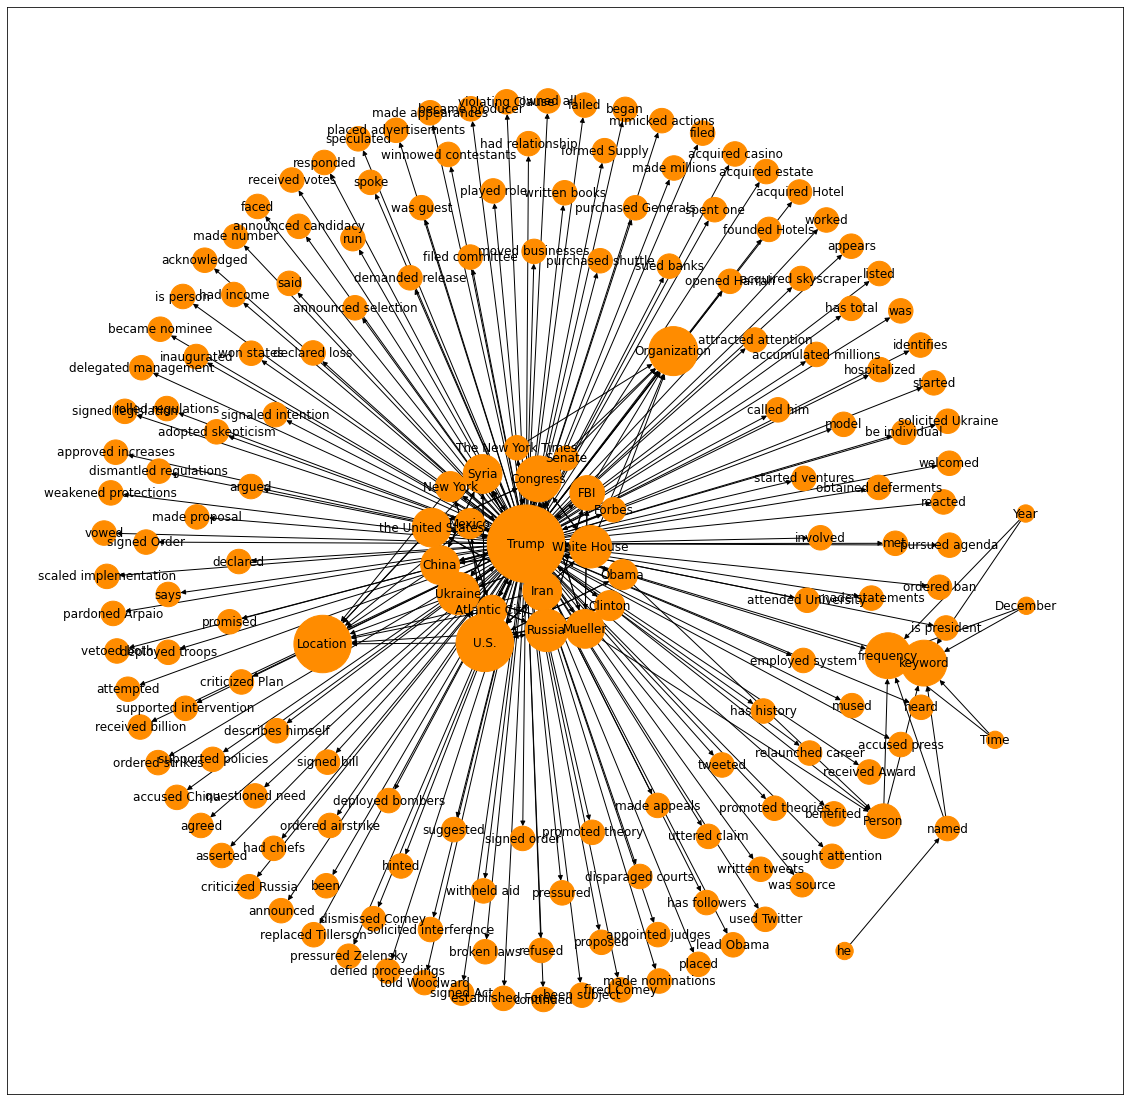

In [7]:
content = WebContentExtractor('https://en.wikipedia.org/wiki/Donald_Trump').extractContent()
# content = WebContentExtractor('https://en.wikipedia.org/wiki/Indian_Space_Research_Organisation').extractContent()
nlp = spacy.load('en_core_web_md')
miner = KnowledgeMining(nlp)
miner.main(content)
# miner.show_nodes()
miner.show_graph()

[0, 1, 1, 1, 2, 1, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 45, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 45, 2, 45, 45, 2, 2, 2, 2, 2, 2]


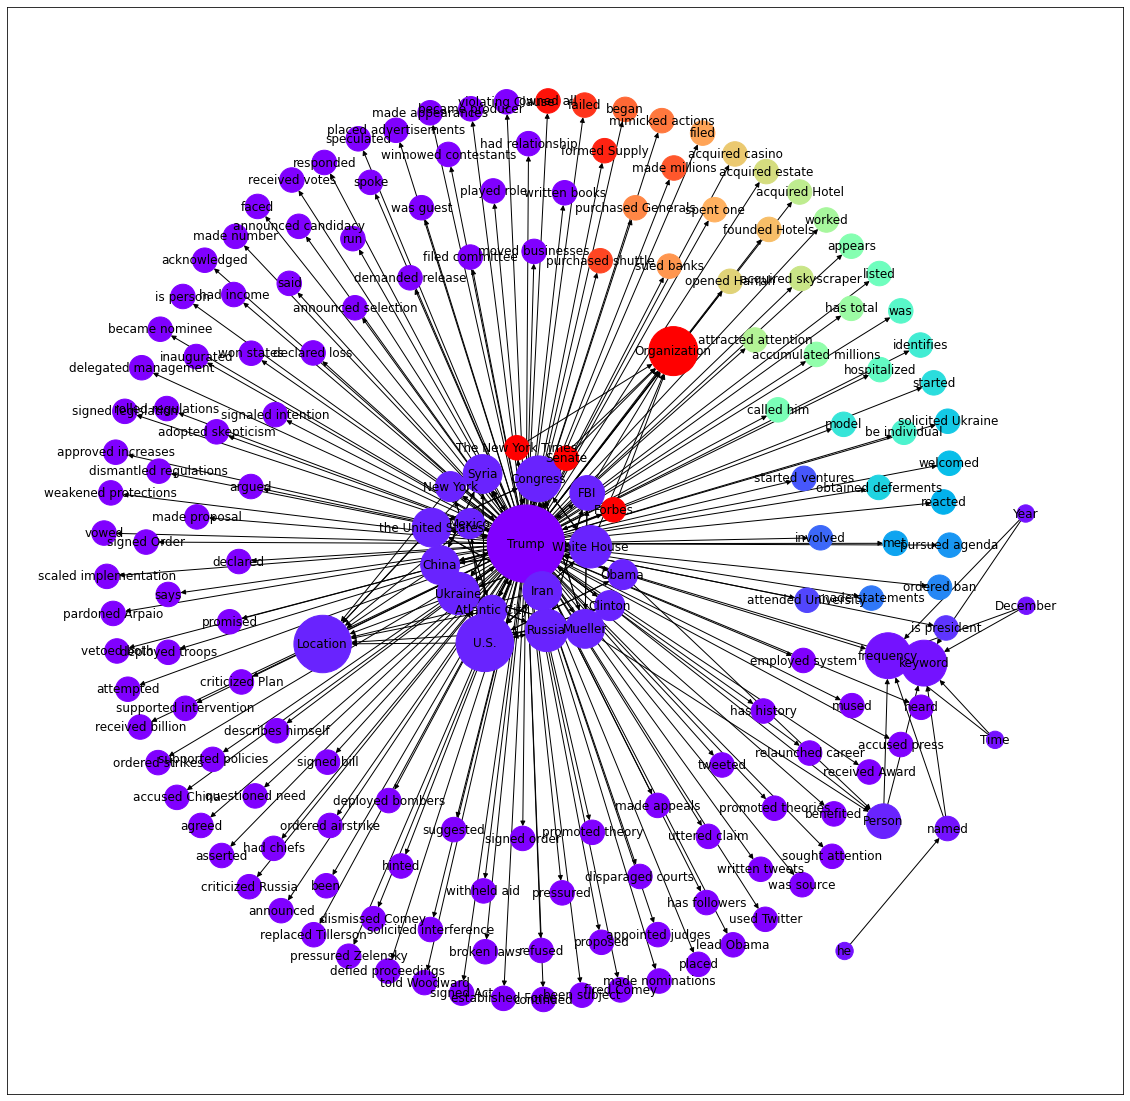

In [8]:
miner.show_communities()